# Anomaly Detection And Recommender Systems

#### Python Implementation

## Anomaly Detection

In [1]:
import numpy as np #linear algebra
from scipy.io import loadmat # read .mat files
import scipy.optimize #fmicg alternative
import matplotlib.pyplot as plt # datavisualization
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

The task is to implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},\ldots,x^{(m)}\}
$. You suspect that the vast majority of these examples are 'normal' (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

In [3]:
#load the data
data = loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval= data['yval']

In [4]:
X.shape

(307, 2)

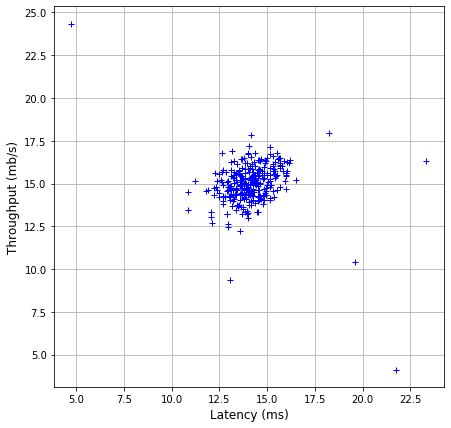

In [5]:
# visualize the data
def plotData(X):
    plt.figure(figsize=(7,7))
    plt.plot(X[:,0],X[:,1],'b+')
    plt.xlabel('Latency (ms)', fontsize=12)
    plt.ylabel('Throughput (mb/s)', fontsize=12)
    plt.grid()

plotData(X)

### Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)}\in\mathbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$ 

The Gaussian distribution is given by
$$p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

To estimate the mean, use:
$$\mu_i = \frac{1}{m}\sum_{j=1}^m{x^{(j)}}$$
and for the variance use:
.$$\sigma^2_i = \frac{1}{m}\sum_{j=1}^m{(x^{(j)}-\mu_j)^2}$$

In [6]:
def estimateGaussian(X):
    m = X.shape[0]
    #mean
    mu = (1/m) * np.sum(X, axis=0)
    #variance
    sigma2 = (1/m) * np.sum((X-mu)**2, axis=0)
    return mu, sigma2

The multivariate gaussian distribution is an extension of anomaly detection and may (or may not) catch more anomalies.
Instead of modeling $p(x_1),p(x_2),\dots$ separately, we will model $p(x)$ all in one go. Our parameters will be: $\mu \in \mathbb{R}^n$ and $\Sigma \in \mathbb{R}^{n \times n}$

$$p(x;\mu,\Sigma) = \dfrac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}} exp(-1/2(x-\mu)^T\Sigma^{-1}(x-\mu))$$

In [7]:
def multivariateGaussian(X,mu,sigma2):
    k = len(mu)
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

In [8]:
#estimate mu and sigma
mu, sigma2 = estimateGaussian(X)

#Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X,mu,sigma2)

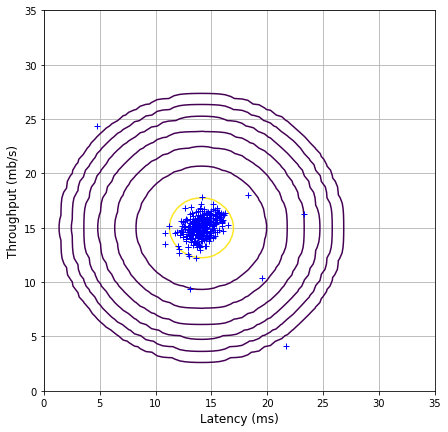

In [9]:
#visualize the fit
plotData(X)
X1,X2 = np.meshgrid(np.linspace(0,35,num=70),np.linspace(0,35,num=70))
Z = multivariateGaussian(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])), mu, sigma2)
plt.contour(X1,X2,Z[:,np.newaxis].reshape(X1.shape),levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
plt.show()

### Selecting the threshold

In [10]:
def selectThreshold(yval,pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(pval) - min(pval))/1000
    for epsilon in np.arange(min(pval),max(pval),stepsize):
        predictions = (pval < epsilon)[:,np.newaxis]
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        
        pre = tp /(tp+fp)
        re = tp /(tp+fn)
        F1 = 2*pre*re /(pre+re)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [11]:

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation:',epsilon)
print('Best F1 on Cross Validation Set: %0.3f' %(F1))

Best epsilon found using cross-validation: 8.990852779269495e-05
Best F1 on Cross Validation Set: 0.875


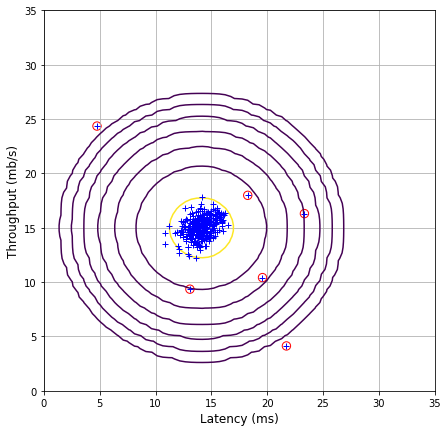

In [12]:
# Visualize the anomalies
plotData(X)
X1,X2 = np.meshgrid(np.linspace(0,35,num=70),np.linspace(0,35,num=70))
Z = multivariateGaussian(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])), mu, sigma2)
plt.contour(X1,X2,Z[:,np.newaxis].reshape(X1.shape),levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])

#anomalies
anomalies = np.nonzero(p<epsilon)[0]
plt.scatter(X[anomalies,0],X[anomalies,1],marker ="o",facecolor="none",edgecolor="r",s=70)

plt.show()

### High dimensional dataset

In this dataset, each example is described by 11 features, capturing many more properties of your compute server

In [13]:
#load the high dimensional data

data2 = loadmat('ex8data2.mat')
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

In [14]:
#Apply the same steps to the larger dataset
mu,sigma2 = estimateGaussian(X)

In [15]:
# Training set probabilities
p = multivariateGaussian(X,mu,sigma2)

#crossvalidation set probabolities
pval =  multivariateGaussian(Xval,mu,sigma2)

In [16]:
# Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: \n', epsilon)
print('Best F1 on Cross Validation Set: \n', F1)
print('Outliers found:\n', np.sum(p < epsilon))

Best epsilon found using cross-validation: 
 1.3772288907613575e-18
Best F1 on Cross Validation Set: 
 0.6153846153846154
Outliers found:
 117


##  Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings*. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$movies.

### Movie ratings dataset

The matrix Y (a num_movies  num_users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix R is an binary-valued indicator matrix, where R(i,j) = 1 if user j gave a rating to movie i, and R(i,j) = 0 otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with R(i,j) = 0. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [17]:
datam = loadmat('ex8_movies.mat')
Y = datam['Y']
R = datam['R']
print(Y.shape, R.shape)

(1682, 943) (1682, 943)


Y is a 1682 x 943 matrix, containing ratings (1 - 5) of 1682 movies on 943 users

R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

In [18]:
data = loadmat("ex8_movieParams.mat")
X = data["X"]
Theta =data["Theta"]
print(X.shape, Theta.shape)

(1682, 10) (943, 10)


The $i$-th row of X corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors.

In [19]:
#From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %0.5f' %(np.mean(Y[0,R[0]==1])))

Average rating for movie 1 (Toy Story): 3.87832


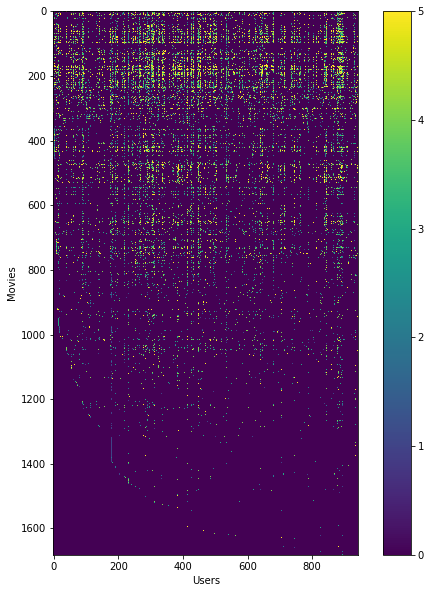

In [20]:
# Visualizing The ratings
plt.figure(figsize=(9, 10))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")
plt.colorbar()
plt.show()

### Collaborative Filtering

The cost function for collaborative filtering with regularization is given by
$$J\left(x^{(i)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}\right)
=\frac{1}{2}\sum_{(i,j):r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)}-y^{(i,j)}\right)^2
+\left(\frac{\lambda}{2}\sum_{j=1}^{n_u}{\sum_{k=1}^{n}{(\theta_k^{(j)})^2}}\right)
+\left(\frac{\lambda}{2}\sum_{i=1}^{n_m}{\sum_{k=1}^{n}{(x_k^{(i)})^2}}\right)$$


the gradients for the regularized cost function is given by:

$$\frac{\partial J}{\partial x_k^{(i)}} 
= \sum_{j:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right)\theta_k^{(j)}+\lambda x_k^{(i)}$$

$$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right) x_k^{(i)}+\lambda\theta_k^{(j)}$$

In [21]:
def cost(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    J = np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R)) / 2
    J += np.sum(np.power(Theta, 2)) * lam / 2
    J += np.sum(np.power(X, 2)) * lam / 2
    return J

In [22]:
def gradient(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    for i in range(num_movies):
        idx = (R[i] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i] = np.dot(np.dot(Theta_temp, X[i]) - Y_temp, Theta_temp)
        X_grad[i] += lam * X[i]
    for i in range(num_users):
        idx = (R[:, i] == 1)
        X_temp = X[idx]
        Y_temp = Y[idx, i]
        Theta_grad[i] = np.dot(np.dot(X_temp, Theta[i]) - Y_temp, X_temp)
        Theta_grad[i] += lam * Theta[i]
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return grad

In [23]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lam):
    J = cost(params, Y, R, num_users, num_movies, num_features, lam)
    grad = gradient(params, Y, R, num_users, num_movies, num_features, lam)
    return J, grad

In [24]:
def checkCostFunction(grad,lam):
    num_grad = np.zeros(len(grad))
    e = 1e-4
    for i in range(len(grad)):
        params1 = params.copy()
        params1[i] += e
        cost1 = cost(params1, Y, R, num_users, num_movies, num_features, lam)
        params2 = params.copy()
        params2[i] -= e
        cost2 = cost(params2, Y, R, num_users, num_movies, num_features, lam)
        num_grad[i] = (cost1 - cost2) / (2 * e)
    print(grad[:5])
    print(num_grad[:5])
    print("Working") if np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9 else print("Not working")

In [25]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [26]:
#Run the cost function without regularization
params = np.hstack((X.ravel(), Theta.ravel()))
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
print(J)

22.224603725685675


In [27]:
checkCostFunction(grad,0)

[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]
[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]
Working


In [28]:
#Run the cost function with regularization
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print(J)
checkCostFunction(grad,1.5)

31.34405624427422
[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]
[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]
Working


###  Learning movie recommendations

In [29]:
# Load the list of movie titles
# The list of all movies and their number in the dataset can be found listed in the file movie_idx.txt.
movie_ids = {}
with open('movie_ids.txt','r') as f:
    for line in f.readlines():
        ids = line.split()[0]
        title = ' '.join(line.split()[1:])
        movie_ids[ids] = title
        
# visualize the first ten titles and ids
for i in range(1,11):
    print(i, movie_ids[str(i)])

1 Toy Story (1995)
2 GoldenEye (1995)
3 Four Rooms (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
7 Twelve Monkeys (1995)
8 Babe (1995)
9 Dead Man Walking (1995)
10 Richard III (1995)


In [30]:
# give my own ratings to some movies
my_ratings = np.zeros((1682,1))

# Rate the movies
my_ratings[0]   = 4
my_ratings[90]  = 2
my_ratings[61]   = 3
my_ratings[13]  = 5
my_ratings[50]  = 4
my_ratings[70]  = 5
my_ratings[56]  = 3
my_ratings[99]  = 5
my_ratings[178] = 4
my_ratings[230] = 5
my_ratings[322] = 5

print('New user ratings: \n')
for i in np.argwhere(my_ratings !=0):
    print(f'Rated {my_ratings[i[0]][0]} for {movie_ids[str(i[0]+1)]}')

New user ratings: 

Rated 4.0 for Toy Story (1995)
Rated 5.0 for Postino, Il (1994)
Rated 4.0 for Legends of the Fall (1994)
Rated 3.0 for Priest (1994)
Rated 3.0 for Stargate (1994)
Rated 5.0 for Lion King, The (1994)
Rated 2.0 for Nightmare Before Christmas, The (1993)
Rated 5.0 for Fargo (1996)
Rated 4.0 for Clockwork Orange, A (1971)
Rated 5.0 for Batman Returns (1992)
Rated 5.0 for Dante's Peak (1997)


### Recommendations

In [31]:
#Reload data
data = loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

print(Y.shape, R.shape)

(1682, 943) (1682, 943)


In [32]:
# add the ratings of the new user to the matrix Y
Y = np.hstack((my_ratings,Y))
Y.shape

(1682, 944)

In [33]:
# add the new column R(i,j) for the new user to matrix R
# remember R(i,j) = 1 if user 1 has rated movie 1 else its 0
R = np.hstack(((my_ratings!=0).astype(int),R))
R.shape

(1682, 944)

In [34]:
#function to normalize the ratings
def normalizeRatings(Y,R):
    m,n = Y.shape[0], Y.shape[1]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros((m,n))
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
        
    return Ynorm, Ymean

In [35]:
#normalize ratings
Ynorm, Ymean = normalizeRatings(Y,R)

In [36]:
#useful variables
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [37]:
#pick random initial parameters of X and Theta
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.hstack((X.ravel(),Theta.ravel()))
lam = 10

In [38]:
#train the model to find optimum results
results = scipy.optimize.minimize(fun=cost, x0=initial_parameters,
                        args=(Ynorm, R, num_users, num_movies, num_features, lam),
                        method='CG', jac=gradient, options={"maxiter": 100})

In [39]:
#unroll the new parameters
X = results.x[:num_movies * num_features].reshape((num_movies, num_features))
Theta = results.x[num_movies * num_features:].reshape((num_users, num_features))

print(X.shape, Theta.shape)

(1682, 10) (944, 10)


To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^T x^{(i)}$

In [40]:
predictions = X.dot(Theta.T)

my_predictions = predictions[:,0] + Ymean.ravel()

In [41]:
#Sort the top ten predictions from the highest to lowest
top = np.argsort(my_predictions)[::-1][:10]

#see the top predictions
print('Top Recomendations for You \n')
for idx in top:
    print(f'Predicting rating {np.round(my_predictions[idx],2)}, for movie {movie_ids[str(idx+1)]}')

#compare with original ratings
print('\nOriginal Ratings: \n')
for i in np.argwhere(my_ratings !=0):
    print(f'Rated {my_ratings[i[0]][0]} for {movie_ids[str(i[0]+1)]}')

Top Recomendations for You 

Predicting rating 5.0, for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0, for movie Star Kid (1997)
Predicting rating 5.0, for movie Santa with Muscles (1996)
Predicting rating 5.0, for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0, for movie Aiqing wansui (1994)
Predicting rating 5.0, for movie They Made Me a Criminal (1939)
Predicting rating 5.0, for movie Great Day in Harlem, A (1994)
Predicting rating 5.0, for movie Someone Else's America (1995)
Predicting rating 5.0, for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0, for movie Prefontaine (1997)

Original Ratings: 

Rated 4.0 for Toy Story (1995)
Rated 5.0 for Postino, Il (1994)
Rated 4.0 for Legends of the Fall (1994)
Rated 3.0 for Priest (1994)
Rated 3.0 for Stargate (1994)
Rated 5.0 for Lion King, The (1994)
Rated 2.0 for Nightmare Before Christmas, The (1993)
Rated 5.0 for Fargo (1996)
Rated 4.0 for Clockwork Orange, A (1971